In [1]:
# set up libraries + backend 
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg' # cleans up backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# conversion factors
GHz = 1.0e9 
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9 
scale_factor = 1e-14 

# Initialize qubit to |0> and extract frequencies from backend
qubit = 0 # ground state qubit
dt = backend_config.dt # backend time-step
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0] 

# assign measurement map
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)
pi_pulse = inst_sched_map.get('x', qubit_meas_group) # Pi pulse from backend

# assign experiment channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Save and retrieve data from external text files
def save_data(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()

def load_data(file):
    filehandler = open(file)
    dataset = json.load(filehandler)
    filehandler.close()
    return dataset

# Define curve fitting function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [2]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # Width of the gaussian pulse
drive_samples_us = drive_sigma_us*8        # Truncates duration of gaussian to be finite
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # Puts width in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # Puts duration in units of dt
drive_amp = 0.3 # Height of gaussian pulse

drive_pulse = pulse_lib.gaussian(duration=drive_samples, sigma=drive_sigma,
                                 amp=drive_amp,name='freq_sweep_excitation_pulse') # Builds pulse

In [3]:
qubit_params = load_data('QubitFrequency.txt')
mod_qubit_freq_Hz = qubit_params['wq'] # from calibration experiment
num_shots = 1024

In [4]:
# now sweep w12 transition
from qiskit.pulse.commands import SamplePulse
def apply_sideband(pulse, freq):
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-mod_qubit_freq_Hz)*t_samples) 
    sideband_pulse = SamplePulse(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse', epsilon=1e-07)
    return sideband_pulse   

# Create function to create qobjs efficiently
def create_excited_freq_sweep_program(freqs, drive_power):
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))
        schedule |= pi_pulse
        schedule |= Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses
        schedules.append(schedule)
    num_freqs = len(freqs)
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=num_shots,
                                          schedule_los=[{drive_chan: mod_qubit_freq_Hz}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

num_freqs = 75
excited_sweep_freqs = mod_qubit_freq_Hz + np.linspace(-400*MHz, 30*MHz, num_freqs)
qubit_exc_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)


In [5]:
qubit_exc_job = backend.run(qubit_exc_freq_sweep_program)
print (qubit_exc_job.job_id())
job_monitor(qubit_exc_job)

5f060e05b96d5f0012c30bfb
Job Status: job has successfully run


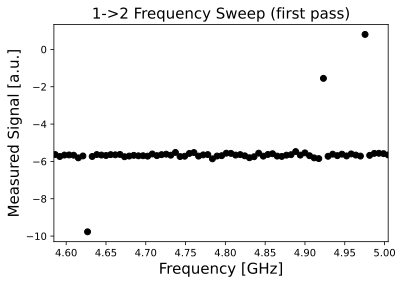

In [6]:
# extract results
from scipy.signal import find_peaks
excited_freq_sweep_data = qubit_exc_job.result(timeout=120)
qubit_exc_sweep_values = []
for i in range(len(excited_freq_sweep_data.results)):
    res = excited_freq_sweep_data.get_memory(i)*scale_factor
    qubit_exc_sweep_values.append(res[qubit])

minima = min(qubit_exc_sweep_values[1:]) #ignore fringe min point
mod_qubit_next_freq = excited_sweep_freqs[qubit_exc_sweep_values.index(minima)] # Minimum point is approx 12 freq 

plt.scatter(excited_sweep_freqs/GHz, np.real(qubit_exc_sweep_values), color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [12]:
# Perform narrower sweep centered at approx freq

refined_excited_sweep_freqs = mod_qubit_next_freq + np.linspace(-5*MHz, 5*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

5f06161849b36f0012cf0161
Job Status: job has successfully run


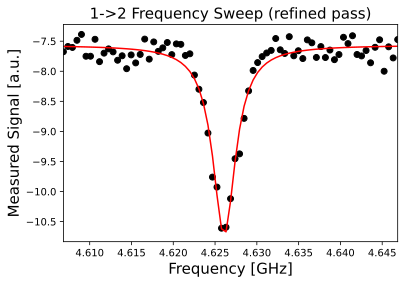

In [11]:
# Extract results

refined_exc_freq_sweep_results = refined_excited_freq_sweep_job.result(timeout=120)
refined_exc_sweep_values = []
for i in range(len(refined_exc_freq_sweep_results.results)):
    res = refined_exc_freq_sweep_results.get_memory(i)*scale_factor
    refined_exc_sweep_values.append(res[qubit])
refined_excited_sweep_fit_params, refined_excited_sweep_y_fit = fit_function(refined_excited_sweep_freqs,
                                     np.real(refined_exc_sweep_values), 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )
_, mod_qubit_12_freq, _, _ = refined_excited_sweep_fit_params
plt.scatter(refined_excited_sweep_freqs/GHz, np.real(refined_exc_sweep_values), color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [14]:
# alpha defined as w12 - w01
alpha_Hz = mod_qubit_12_freq - mod_qubit_freq_Hz

In [16]:
print(f"Alpha is {alpha_Hz / MHz} MHz")

Alpha is -348.472207172225 MHz


In [1]:
alpha_MHz = -348.472207172225
alpha_val = {'alpha_MHz': alpha_MHz}

save_data(alpha_val, 'Nonlinearity.txt')

4.626082792827774